In [21]:
import qiskit.tools.jupyter
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, execute
from qiskit.tools.visualization import plot_histogram, plot_distribution
from qiskit.circuit.library import MCMT
from qiskit.circuit.classicalfunction.boolean_expression import BooleanExpression
from qiskit.algorithms import Grover, AmplificationProblem
from qiskit.utils import QuantumInstance
from qiskit.algorithms import Grover, AmplificationProblem
from qiskit.circuit.library import PhaseOracle, OR
import matplotlib.pyplot as plt
import numpy as np

In [22]:
def execute_circuit(qc, shots=1024, decimal=False, reversed=False):
    
    #define backend
    device = Aer.get_backend('qasm_simulator')
    #get counts
    counts = execute(qc, device ,shots=shots).result().get_counts()
    
    if decimal:
        if reversed:
            counts = dict((int(a[::-1],2),b) for (a,b) in counts.items())
        else:
            counts = dict((int(a,2),b) for (a,b) in counts.items())
    else:
        if reversed:
            counts = dict((a[::-1],b) for (a,b) in counts.items())
        else:
            counts = dict((a,b) for (a,b) in counts.items())

    return counts

f(v1,v2,v3) = ( ¬v1 ∨ ¬v2 ∨ ¬v3) ∧ (v1 ∨ ¬v2 ∨ v3) ∧ (v1 ∨ v2 ∨ ¬v3) ∧ (v1 ∨ ¬v2 ∨ ¬v3) ∧ ( ¬v1 ∨ v2 ∨ v3)

In [23]:
expression = '''
c example DIMACS CNF 3-SAT
p cnf 3 5
-1 -2 -3 0
1 -2 3 0
1 2 -3 0
1 -2 -3 0
-1 2 3 0
'''

with open('dimacs.txt', 'r') as f:
    expression = f.read()



In [50]:
def func (expression):
    lines = expression.split("\n")
    print(lines)
    n_qibits = int(lines[1].split(" ")[2])
    n_formulas = int(lines[1].split(" ")[3])

    qr = QuantumRegister(n_qibits, name = "psi")
    ancilla = QuantumRegister(n_formulas, name = "ancilla")
    result = QuantumRegister(1,name = "result")
    cr = ClassicalRegister(n_qibits)

    qc = QuantumCircuit(qr,ancilla,result,cr)

    #uniform superposition qr

    qc.h(qr)

    #|-> state ancilla
    qc.x(ancilla)
    qc.h(ancilla)
    
    #|-> state result
    qc.x(result)
    qc.h(result)
    elements = 2**n_qibits

    iterations= int(np.floor(np.pi/4 * np.sqrt(elements)))

    for j in range(iterations):

        qc.barrier()

        #Oracle
        for i in range(n_formulas):
            #Oracle
            valores = []
            line = lines[i+2].split(" ")
            for j in range(n_qibits):
                if line[j][0] == '-':
                    valores.append(-1)
                else:
                    valores.append(1)
            valores += [0 for a in range(i)]
            print(valores)
            c6z = OR(n_qibits+i,flags=valores)
            qc = qc.compose(c6z)
            qc.barrier()

        #diffusion operator


        qc.h(qr)
        qc.x(qr)
        c3z= MCMT('cz',n_qibits-1,1)
        qc.compose(c3z,qubits=range(n_qibits),inplace=True)
        qc.x(qr)
        qc.h(qr)
        
        qc.barrier()
        #qc.x(ancilla)
        qc.mct(ancilla,result)
        
        qc.barrier()
    qc.h(qr)
    qc.x(qr)
    c3z= MCMT('cz',n_qibits-1,1)
    qc.compose(c3z,qubits=range(n_qibits),inplace=True)
    qc.x(qr)
    qc.h(qr)
    
    qc.barrier()

        
    
    #for i in range(2,len(lines)):
    return qc,qr,cr



['c example DIMACS CNF 3-SAT', 'p cnf 3 5', '-1 -2 -3 0', '1 -2 3 0', '1 2 -3 0', '1 -2 -3 0', '-1 2 3 0']
[-1, -1, -1]
[1, -1, 1, 0]
[1, 1, -1, 0, 0]
[1, -1, -1, 0, 0, 0]
[-1, 1, 1, 0, 0, 0, 0]
[-1, -1, -1]
[1, -1, 1, 0]
[1, 1, -1, 0, 0]
[1, -1, -1, 0, 0, 0]
[-1, 1, 1, 0, 0, 0, 0]


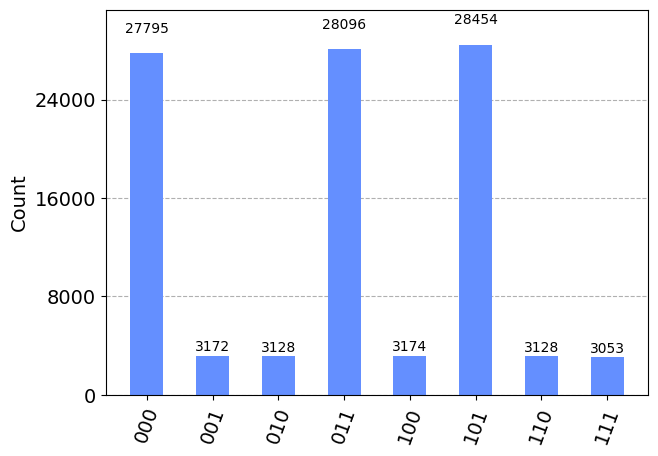

In [51]:
qc,qr,cr = func(expression)
qc.measure(qr,cr)
#qc.measure_all()
counts = execute_circuit(qc,shots= 100000)
plot_histogram(counts)

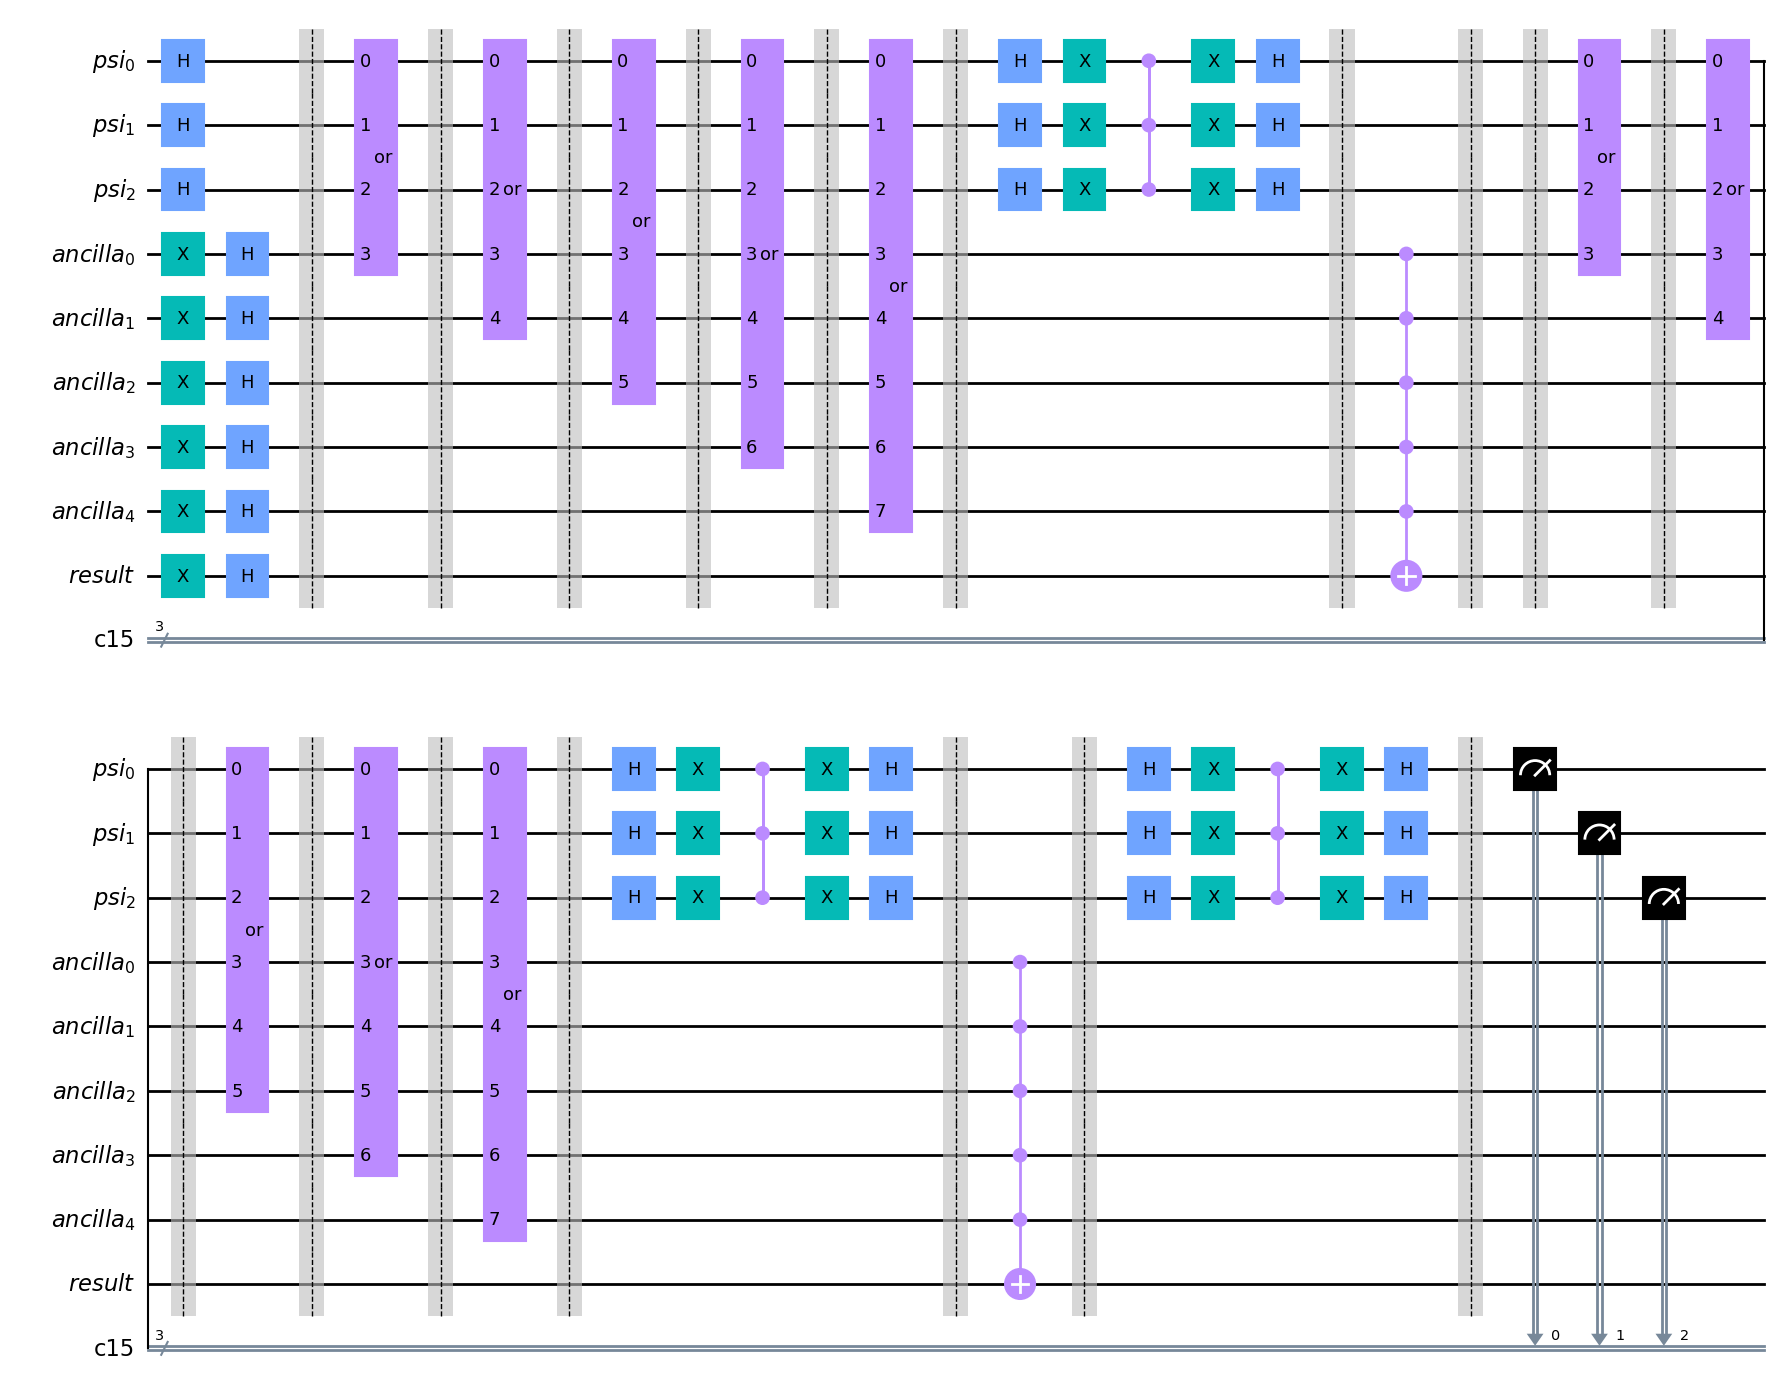

In [52]:
qc.draw(output="mpl")

# EXEMPLO USANDO ORACLE

In [165]:
def func1 (expression):
    oracle = PhaseOracle.from_dimacs_file('dimacs.txt')
    lines = expression.split("\n")[1:]
    print(lines)
    n_qibits = int(lines[1].split(" ")[2])
    n_formulas = int(lines[1].split(" ")[3])

    qr = QuantumRegister(n_qibits, name = "psi")
    cr = ClassicalRegister(n_qibits)

    qc = QuantumCircuit(qr,cr)

    #uniform superposition qr

    qc.h(qr)
    

    elements = 2**n_qibits

    iterations= int(np.floor(np.pi/4 * np.sqrt(elements)))

    for j in range(iterations):

        qc.barrier()
        qc = qc.compose(oracle)
        qc.barrier()
        
        #diffusion operator


        qc.h(qr)
        qc.x(qr)
        c3z= MCMT('cz',n_qibits-1,1)
        qc.compose(c3z,qubits=range(n_qibits),inplace=True)
        qc.x(qr)
        qc.h(qr)
        
        qc.barrier()
    
    #for i in range(2,len(lines)):
    return qc,qr,cr



In [178]:
qc,qr,cr = func1(expression)
qc.measure(qr,cr)
#qc.measure_all()
counts = execute_circuit(qc,shots= 100000)
plot_histogram(counts)

AttributeError: 'BooleanExpression' object has no attribute 'split'

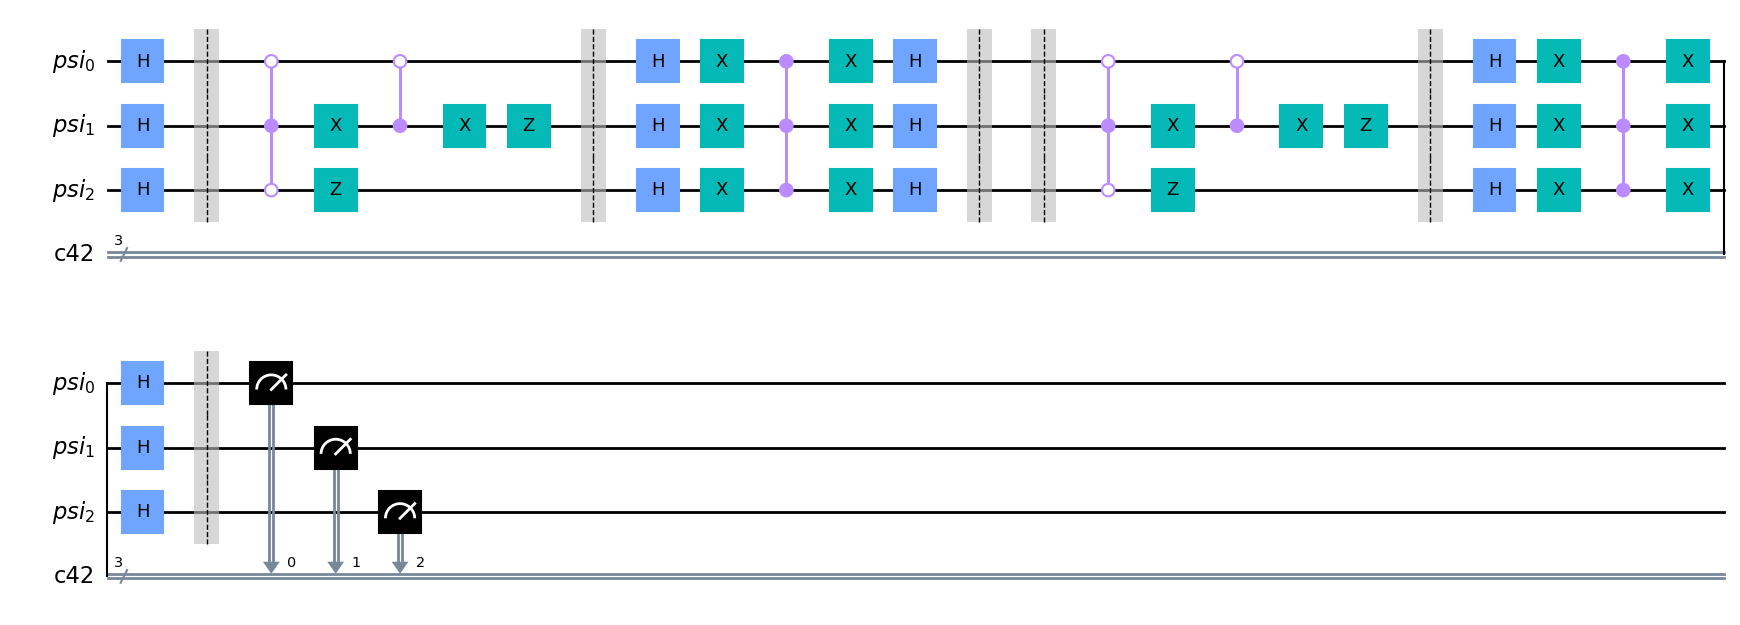

In [154]:
qc.draw(output="mpl")

In [177]:
expression = '(~v1 | ~v2 | ~v3) & (v1 | ~(v2) | v3)&  (v1 | v2 | ~(v3))& (v1 | ~(v2) | ~(v3))&  (~(v1) | v2 |v3)'
expression = BooleanExpression(expression)
def synthesizer(boolean_expression):
                from tweedledum.synthesis import pkrm_synth  # pylint: disable=import-error
                from qiskit.circuit.classicalfunction.utils import tweedledum2qiskit

                truth_table = boolean_expression._tweedledum_bool_expression.truth_table(
                    output_bit=0
                )
                tweedledum_circuit = pkrm_synth(truth_table, {"pkrm_synth": {"phase_esop": True}})
                return tweedledum2qiskit(tweedledum_circuit)
#v = Verifier('dimacs.txt')

print(expression._tweedledum_bool_expression.truth_table(output_bit=0))
oracle = expression.synth(synthesizer=synthesizer)

00101001


### TruthTable

In [ ]:
def solucao(expression,param):
    lines = expression.split("\n")
    print(lines)
    n_qibits = int(lines[1].split(" ")[2])
    n_formulas = int(lines[1].split(" ")[3])
    #Oracle
    for i in range(n_formulas):
        #Oracle
        valores = []
        line = lines[i+2].split(" ")
    for j in range(n_qibits):
            if line[j][0] == '-':
                if param[j] != 0:
                    return false
            else:
                if param[j] == 0:
                    return false
    return true
        valores += [0 for a in range(i)]
        print(valores)
        c6z = OR(n_qibits+i,flags=valores)
        qc = qc.compose(c6z)
        qc.barrier()